In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

In [2]:
input_path = "../data/"
data = pd.read_csv(input_path +"used_car_dataset.csv")

In [3]:
## drop rows with na values (I tried to fill it with mean value and -1 but the final RMSE increased)
data = data.dropna()
# data = data.fillna(data.mean())
# data = data.fillna(-1)

In [4]:
## Split Train, Test data
## allocate predictors to X
X = data.iloc[:,1:]

## allocate test value to y
y = data["price"]

## Train, validation, test split applying random state
## Train : Validation : Test = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [5]:
## make training set, validation set, test set
train_set = X_train
train_set["price"] = y_train
val_set = X_val
val_set["price"] = y_val
test_set = X_test
test_set["price"] = y_test

# Data Exploration

In [6]:
train_set.describe()

,year,odometer,F1,F2,F3,price
count,7536.000000,7.536000e+03,7536.000000,7536.000000,7536.000000,7536.000000
mean,2010.224257,1.143590e+05,1570.520435,2.233493,0.100414,14583.627787
std,7.928370,1.400875e+05,2141.258780,0.207119,0.101076,13013.322373
min,1923.000000,0.000000e+00,7.000000,0.218594,-0.308592,0.000000
25%,2007.000000,6.751350e+04,316.750000,2.137262,0.030985,5754.500000
50%,2012.000000,1.108375e+05,733.500000,2.258836,0.101411,10558.000000
75%,2015.000000,1.508305e+05,2154.500000,2.362769,0.168508,19961.750000
max,2021.000000,9.999999e+06,36773.000000,2.728576,0.526848,402498.000000


In [7]:
train_set.dtypes

year            float64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
transmission     object
type             object
paint_color      object
F1                int64
F2              float64
F3              float64
F4               object
price           float64
dtype: object

## price

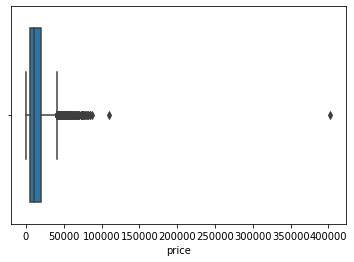

In [8]:
#### remove outliers!
ax = sns.boxplot(x=train_set["price"])

In [9]:
## the datapoints located outside of the boxplot can be interpreted as outliers.
#However, I will not consider all of the datapoints located outside of the box as outlier
#since some data points are concentrated on the area
#price below 100000 seems to be reasonable.
train_set = train_set[train_set["price"]<100000]
X_train = train_set.iloc[:,:-1]
y_train = train_set["price"]

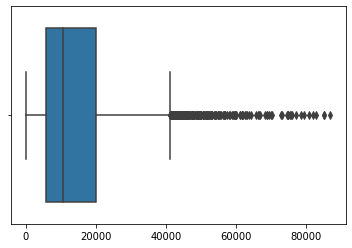

In [10]:
import seaborn as sns
# sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train_set[["price"]])

## Year

In [11]:
## correlation between year and price
train_set['year'].corr(train_set['price'])

#https://stackoverflow.com/questions/42579908/use-corr-to-get-the-correlation-between-two-columns

0.40221568504693306

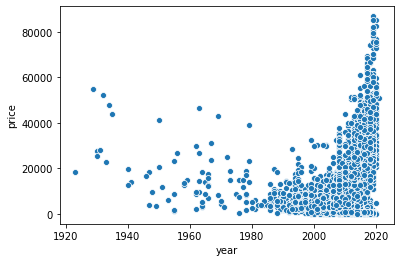

In [12]:
## year vs price
ax = sns.scatterplot(x="year", y="price", data=train_set)

In [13]:
## the ratio of cars manufactured before 1980
len(train_set[train_set["year"]<1980])/len(train_set)

0.009689408016989648

In [14]:
## the ratio of cars manufactured after 1980
len(train_set[train_set["year"]>=1980])/len(train_set)

0.9903105919830103

In [15]:
## linear model (price ~ year) for the cars manufactured before 1980
train_set1 = train_set[train_set["year"]<1980]
X1 = sm.add_constant(train_set1["year"])
est = sm.OLS(train_set1["price"], X1).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     13.26
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           0.000512
Time:                        16:40:28   Log-Likelihood:                -787.79
No. Observations:                  73   AIC:                             1580.
Df Residuals:                      71   BIC:                             1584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.856e+05   1.84e+05      3.734      0.0

In [16]:
## linear model (price ~ year) for the cars manufactured after 1980
train_set1 = train_set[train_set["year"]>=1980]
X1 = sm.add_constant(train_set1["year"])
est = sm.OLS(train_set1["price"], X1).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     3453.
Date:                Mon, 08 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:40:28   Log-Likelihood:                -79347.
No. Observations:                7461   AIC:                         1.587e+05
Df Residuals:                    7459   BIC:                         1.587e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.271e+06   3.89e+04    -58.392      0.0

## type

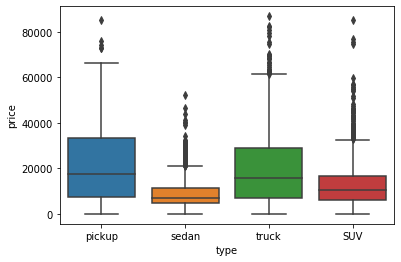

In [17]:
### type of car vs price
ax = sns.boxplot(x="type", y="price", data=train_set)

In [18]:
print('pickup :' ,train_set[train_set['type'] == "pickup"]["price"].mean())
print('sedan :' ,train_set[train_set['type'] == 'sedan']["price"].mean())
print('truck :' ,train_set[train_set['type'] == "truck"]["price"].mean())
print('SUV :' ,train_set[train_set['type'] == "SUV"]["price"].mean())

pickup : 20240.992509363296
sedan : 8822.149899396378
truck : 19007.47894736842
SUV : 12425.29035049762


## manufacturer

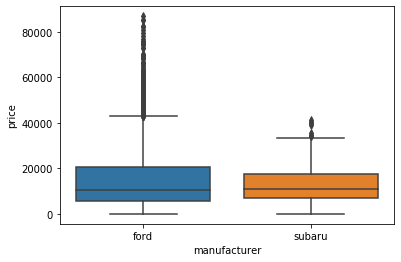

In [19]:
## manufacturer vs price
ax = sns.boxplot(x="manufacturer", y="price", data=train_set)

# condition

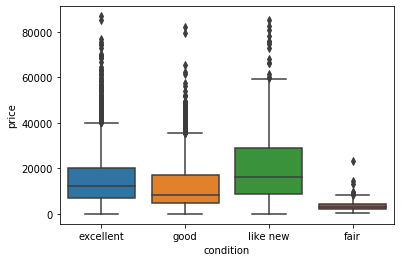

In [20]:
## condition vs price
ax = sns.boxplot(x="condition", y="price", data=train_set)

In [21]:
print('Like new :' ,train_set[train_set['condition'] == "like new"]["price"].mean())
print('Excellent :' ,train_set[train_set['condition'] == "excellent"]["price"].mean())
print('Good :' ,train_set[train_set['condition'] == "good"]["price"].mean())
print('Fair :' ,train_set[train_set['condition'] == "fair"]["price"].mean())

Like new : 19777.620283018867
Excellent : 15158.715320633217
Good : 12987.886882829771
Fair : 3559.738775510204


## Cylinders

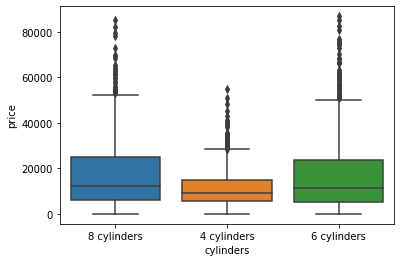

In [22]:
## cylinders vs price
ax = sns.boxplot(x="cylinders", y="price", data=train_set)

## Fuel

In [23]:
## fuel vs price --> only one value
train_set.fuel.unique()

array(['gas'], dtype=object)

In [24]:
# since fuel has only one value "gas", it is not informative. So delete fuel column
train_set = train_set.drop(["fuel"], axis =1)
val_set = val_set.drop(["fuel"], axis =1)
test_set = test_set.drop(["fuel"], axis =1)

## Odometer

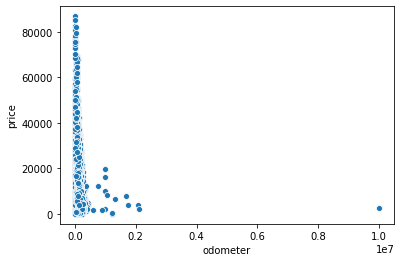

In [26]:
## odometer vs price
ax = sns.scatterplot(x="odometer", y="price", data=train_set)

In [27]:
## remove outlier in training set
train_set = train_set[train_set["odometer"]<0.4*(10**7)]
X_train = train_set.iloc[:,:-1]
y_train = train_set["price"]

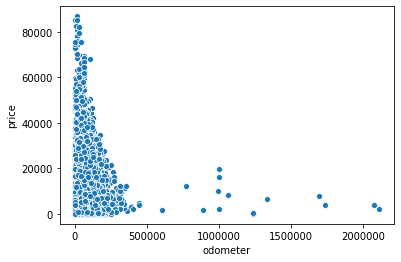

In [28]:
## odometer vs price
ax = sns.scatterplot(x="odometer", y="price", data=train_set)

In [29]:
## remove outlier in training set
train_set = train_set[train_set["odometer"]<5*(10**5)]
X_train = train_set.iloc[:,:-1]
y_train = train_set["price"]

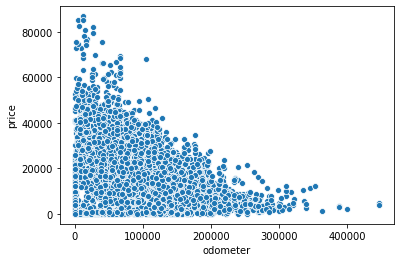

In [30]:
## odometer vs price
ax = sns.scatterplot(x="odometer", y="price", data=train_set)
## When odometer is less than 500000

In [31]:
## correlation btw odometer and price
train_set["odometer"].corr(train_set["price"])

-0.5260478905893958

In [32]:
## linear model (price ~ odometer) for the cars manufactured before 1980
train_set1 = train_set[train_set["odometer"]<500000]
X1 = sm.add_constant(train_set1["odometer"])
est = sm.OLS(train_set1["price"], X1).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     2876.
Date:                Mon, 08 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:40:29   Log-Likelihood:                -80174.
No. Observations:                7518   AIC:                         1.604e+05
Df Residuals:                    7516   BIC:                         1.604e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.62e+04    248.166    105.582      0.0

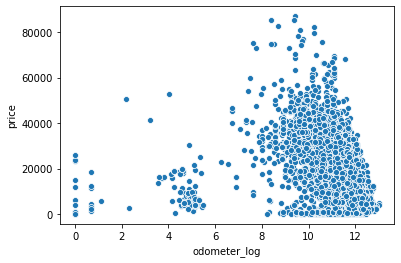

In [33]:
## Check how the distribution looks like when log function is applied
train_set["odometer_log"] = train_set["odometer"].apply(lambda x: math.log(x+1))
val_set["odometer_log"] = val_set["odometer"].apply(lambda x: math.log(x+1))
test_set["odometer_log"] = test_set["odometer"].apply(lambda x: math.log(x+1))

## odometer vs price
ax = sns.scatterplot(x="odometer_log", y="price", data=train_set)

### If odometer is too low, the price was low. ==> Too new car had low price. Maybe there will be defect.
### If log(odometer) is between 7, odometer showed light negative relation with price.

In [34]:
## Create dummy variable which says whether log(odometer) is in the adequate range.

def odo_dumy(x):
    if x<7:
        return 1
    else:
        return 0

In [35]:
train_set["odometer_log_dummy"] = train_set["odometer_log"].apply(lambda x: odo_dumy(x))
val_set["odometer_log_dummy"] = val_set["odometer_log"].apply(lambda x: odo_dumy(x))
test_set["odometer_log_dummy"] = test_set["odometer_log"].apply(lambda x: odo_dumy(x))

In [36]:
### checking the effect of odometer when log(odometer)>7
data_1 = train_set[train_set["odometer_log"]>7]

data_1_X = data_1["odometer"]
data_1_y = data_1["price"]

data_1_X = sm.add_constant(data_1_X)

est = sm.OLS(data_1_y, data_1_X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     3352.
Date:                Mon, 08 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:40:30   Log-Likelihood:                -78628.
No. Observations:                7390   AIC:                         1.573e+05
Df Residuals:                    7388   BIC:                         1.573e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.75e+04    251.586    109.288      0.0

# Transmission

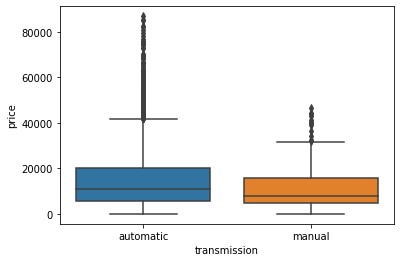

In [37]:
## transmission vs price
ax = sns.boxplot(x="transmission", y="price", data=train_set)

# Type

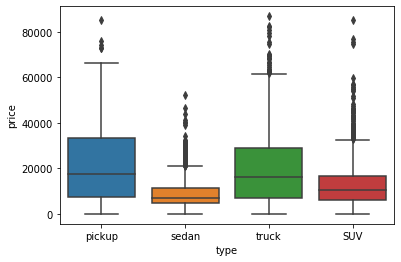

In [38]:
## type vs price
ax = sns.boxplot(x="type", y="price", data=train_set)

# paint_color

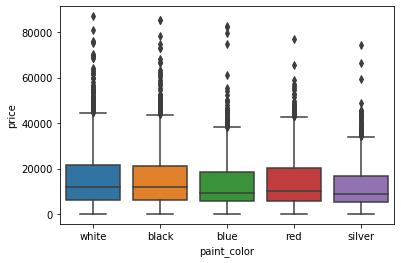

In [39]:
## paint_color vs price
ax = sns.boxplot(x="paint_color", y="price", data=train_set)

# F1

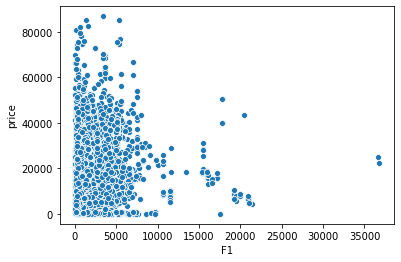

In [40]:
## F1 vs price
ax = sns.scatterplot(x="F1", y="price", data=train_set)

In [41]:
### linear regression for F1
data1 = train_set[train_set["F1"]<10000]
## minmax scaled to test the impact
F1_max = data1["F1"].max()
F1_min = data1["F1"].min()
F1_mean = data1["F1"].mean()

data1["F1_scaled"] = data1["F1"].apply(lambda x: ((x-F1_mean)/(F1_max-F1_min)))

lm=ols('price ~ F1_scaled', data=data1).fit()
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     711.9
Date:                Mon, 08 Feb 2021   Prob (F-statistic):          7.04e-150
Time:                        16:40:30   Log-Likelihood:                -80370.
No. Observations:                7454   AIC:                         1.607e+05
Df Residuals:                    7452   BIC:                         1.608e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.453e+04    134.967    107.671      0.0

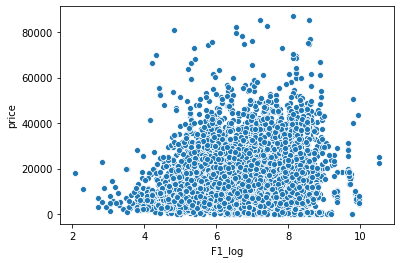

In [42]:
## Check how the distribution looks like when log function is applied --> not interesting
train_set["F1_log"] = train_set["F1"].apply(lambda x: math.log(x+1))
val_set["F1_log"] = val_set["F1"].apply(lambda x: math.log(x+1))
test_set["F1_log"] = test_set["F1"].apply(lambda x: math.log(x+1))

## F1 vs price
ax = sns.scatterplot(x="F1_log", y="price", data=train_set)

# F2

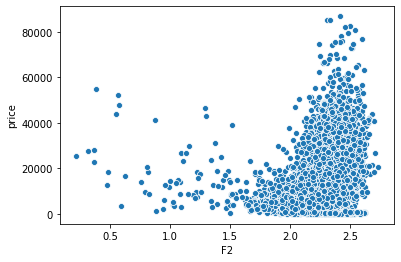

In [43]:
## F2 vs price
ax = sns.scatterplot(x="F2", y="price", data=train_set)

In [44]:
### linear regression for F2

data1 = train_set[train_set["F2"]>1.5]
## minmax scaled to test the impact
F2_max = data1["F2"].max()
F2_min = data1["F2"].min()
F2_mean = data1["F2"].mean()

data1["F2_scaled"] = data1["F2"].apply(lambda x: ((x-F2_mean)/(F2_max-F2_min)))
lm=ols('price ~ F2_scaled', data=data1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     1833.
Date:                Mon, 08 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:40:31   Log-Likelihood:                -79852.
No. Observations:                7452   AIC:                         1.597e+05
Df Residuals:                    7450   BIC:                         1.597e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.451e+04    126.291    114.928      0.0

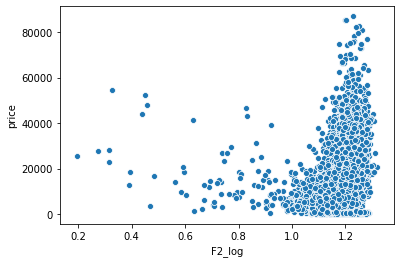

In [45]:
## Check how the distribution looks like when log function is applied --> not interesting
train_set["F2_log"] = train_set["F2"].apply(lambda x: math.log(x+1))
val_set["F2_log"] = val_set["F2"].apply(lambda x: math.log(x+1))
test_set["F2_log"] = test_set["F2"].apply(lambda x: math.log(x+1))

## F2 vs price
ax = sns.scatterplot(x="F2_log", y="price", data=train_set)

# F3

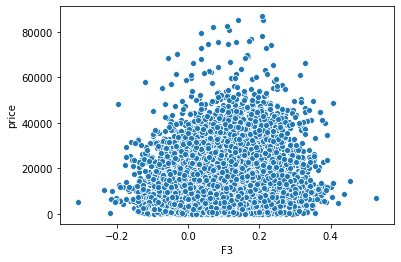

In [46]:
## F3 vs price
ax = sns.scatterplot(x="F3", y="price", data=train_set)

In [47]:
### linear regression for F3

data1 = train_set
## minmax scaled to test the impact
F3_max = data1["F3"].max()
F3_min = data1["F3"].min()
F3_mean = data1["F3"].mean()
data1["F3_scaled"] = data1["F3"].apply(lambda x: ((x-F3_mean)/(F3_max-F3_min)))
lm=ols('price ~ F3_scaled', data=train_set).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     80.01
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           4.62e-19
Time:                        16:40:31   Log-Likelihood:                -81352.
No. Observations:                7518   AIC:                         1.627e+05
Df Residuals:                    7516   BIC:                         1.627e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.454e+04    139.713    104.050      0.0

In [48]:
train_set = train_set.drop("F3_scaled", axis =1)

# F4 

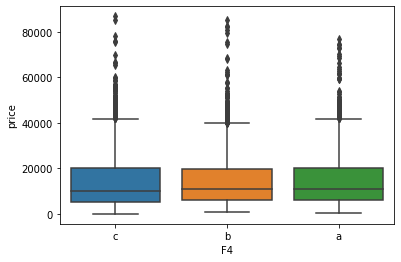

In [49]:
## F4 vs price
ax = sns.boxplot(x="F4", y="price", data=train_set)

In [50]:
### linear regression for F4
lm=ols('price ~ F4', data=train_set).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5270
Date:                Mon, 08 Feb 2021   Prob (F-statistic):              0.590
Time:                        16:40:31   Log-Likelihood:                -81391.
No. Observations:                7518   AIC:                         1.628e+05
Df Residuals:                    7515   BIC:                         1.628e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.464e+04    245.587     59.594      0.0

In [51]:
### To measure the impact of F4 feature, I am using anova.
## Anova is proper way to measure because it has 3 groups a,b,c.

linear_model=ols('price ~ F4', data=data).fit()
print(sm.stats.anova_lm(linear_model, typ=2))


##https://stackoverflow.com/questions/25537399/anova-in-python-using-pandas-dataframe-with-statsmodels-or-scipy

                sum_sq      df         F    PR(>F)
F4        5.028198e+07     2.0  0.154935  0.856473
Residual  1.509420e+12  9302.0       NaN       NaN


As p-value is 0.85 and it is higher than 0.05, there is no significant difference in price between a,b,c three groups of F4

# preprocessing

In [52]:
## change categorical variable to numerical variable
def manufacturer(x):
    if x == "ford":
        return 0
    elif x == "subaru":
        return 1
    else:
        print("no")
train_set["manufacturer"] = train_set["manufacturer"].apply(lambda x: manufacturer(x))
val_set["manufacturer"] = val_set["manufacturer"].apply(lambda x: manufacturer(x))
test_set["manufacturer"] = test_set["manufacturer"].apply(lambda x: manufacturer(x))


In [53]:
def condition(x):
    if x == 'fair':
        return 0
    if x == 'good':
        return 1
    if x == 'like new':
        return 3
    if x == 'excellent':
        return 2
train_set["condition"] = train_set["condition"].apply(lambda x: condition(x))
val_set["condition"] = val_set["condition"].apply(lambda x: condition(x))
test_set["condition"] = test_set["condition"].apply(lambda x: condition(x))

In [54]:
def cylinder(x):
    if x == "6 cylinders":
        return 6
    if x == "8 cylinders":
        return 8
    if x == "4 cylinders":
        return 4
train_set["cylinders"] = train_set["cylinders"].apply(lambda x: cylinder(x))
val_set["cylinders"] = val_set["cylinders"].apply(lambda x: cylinder(x))
test_set["cylinders"] = test_set["cylinders"].apply(lambda x: cylinder(x))

In [55]:
data.transmission.unique()
## change categorical variable to categorical variable
def transmission(x):
    if x == "automatic":
        return 0
    elif x == "manual":
        return 1
    else:
        print("no")
train_set["transmission"] = train_set["transmission"].apply(lambda x: transmission(x))
val_set["transmission"] = val_set["transmission"].apply(lambda x: transmission(x))
test_set["transmission"] = test_set["transmission"].apply(lambda x: transmission(x))

In [56]:
## year starts from 1922 --> scale down year by subtraacting 1922
train_set["year"]=train_set["year"].apply(lambda x : x-1922)
val_set["year"]=val_set["year"].apply(lambda x : x-1922)
test_set["year"]=test_set["year"].apply(lambda x : x-1922)

In [57]:
## created dummy variables with pd.get_dummies. (one-hot-encoding)
## used onehot encoding and dropped the first columns for each categorical variable to avoid multicolinearity problem
train_set = pd.get_dummies(data=train_set, drop_first=True)
val_set = pd.get_dummies(data=val_set, drop_first=True)
test_set = pd.get_dummies(data=test_set, drop_first=True)
train_set.head()

##https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c

,year,manufacturer,condition,cylinders,odometer,transmission,F1,F2,F3,price,...,F2_log,type_pickup,type_sedan,type_truck,paint_color_blue,paint_color_red,paint_color_silver,paint_color_white,F4_b,F4_c
7003,94.0,0,2,8,174297.0,0,1744,2.252671,-0.134080,15582.0,...,1.179477,1,0,0,0,0,0,1,0,1
6149,90.0,0,1,4,105000.0,0,250,2.267992,0.013700,8403.0,...,1.184176,0,1,0,0,0,0,1,1,0
3689,88.0,0,1,8,180200.0,0,2299,2.269702,0.128711,11731.0,...,1.184699,0,0,1,0,0,0,1,0,0
1718,91.0,0,2,4,115000.0,0,682,2.274229,0.053494,7901.0,...,1.186083,0,0,0,0,0,0,1,0,1
526,89.0,1,1,4,103371.0,0,2493,2.425471,0.095257,8758.0,...,1.231239,0,0,0,0,0,0,0,0,1


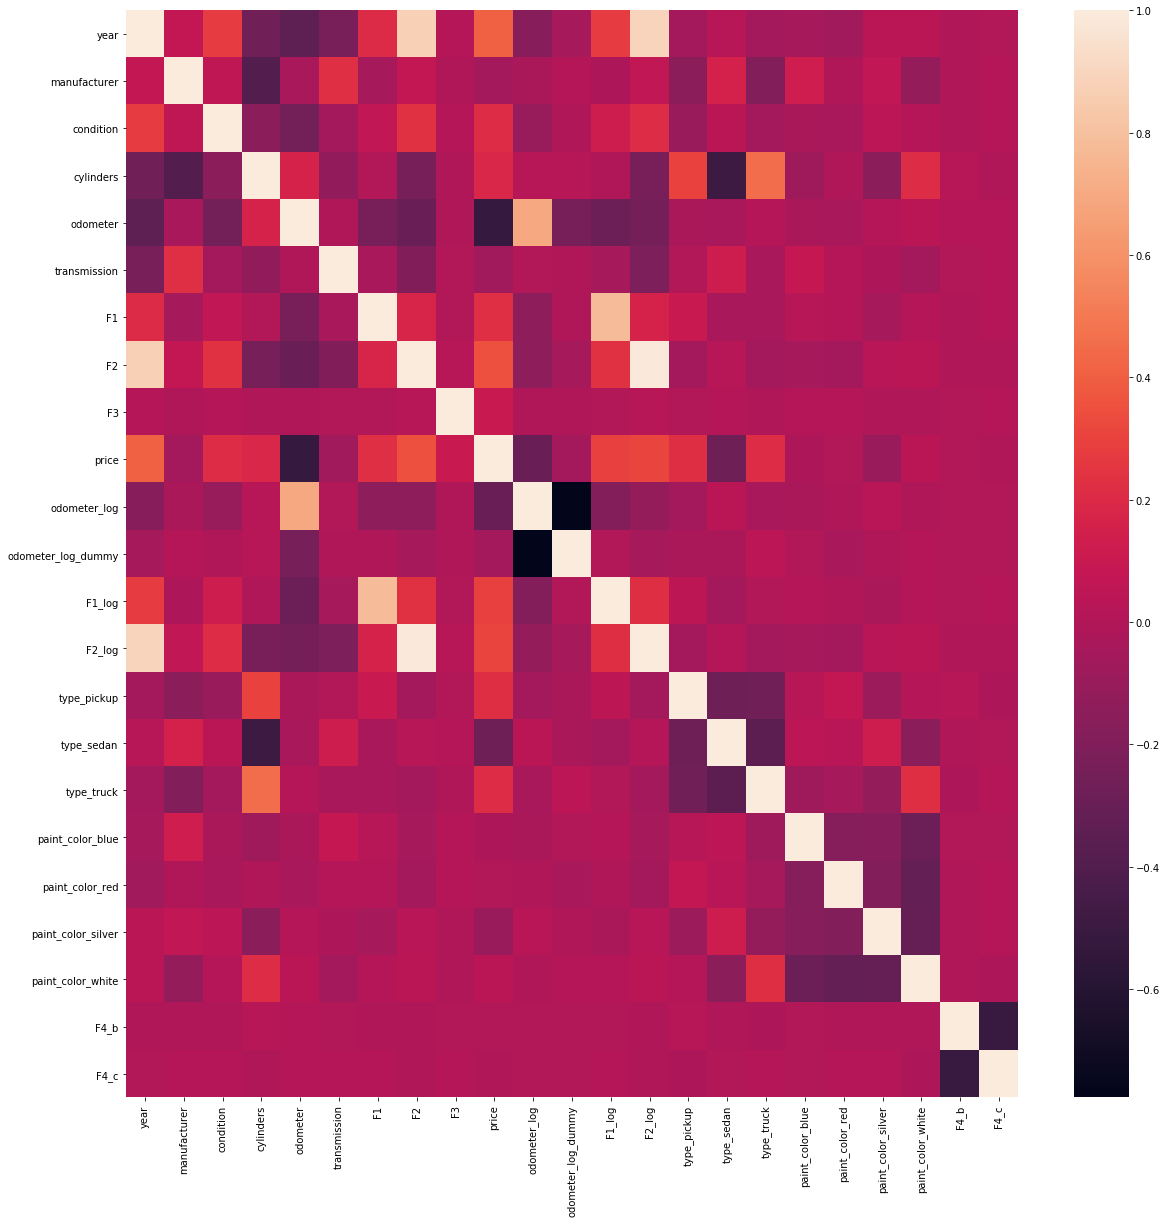

In [58]:
## correlation heatmap of data

f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(train_set.corr())

#https://seaborn.pydata.org/generated/seaborn.heatmap.html

### New cars are expensive, F2 has positive correlation with price
### F2 and year seems to have positive correlation
### Sedan does not have many cylinders
### Truck have many cylinders
### Manufacturer subaru does not make cars with many cylinders

In [59]:
## Year and F2 seems to have high correlation. --> drop F2
## F2 and F2_log has high corelation --> drop F2_log
train_set = train_set.drop(["F2"], axis = 1)
val_set = val_set.drop(["F2"], axis = 1)
test_set = test_set.drop(["F2"], axis = 1)
train_set = train_set.drop(["F2_log"], axis = 1)
val_set = val_set.drop(["F2_log"], axis = 1)
test_set = test_set.drop(["F2_log"], axis = 1)

In [60]:
## correlation matrix of data
train_set.corr()

,year,manufacturer,condition,cylinders,odometer,transmission,F1,F3,price,odometer_log,...,F1_log,type_pickup,type_sedan,type_truck,paint_color_blue,paint_color_red,paint_color_silver,paint_color_white,F4_b,F4_c
year,1.000000,0.070750,0.273174,-0.266966,-0.341448,-0.229671,0.205671,0.012863,0.404317,-0.167781,...,0.272459,-0.058481,0.024781,-0.057807,-0.047835,-0.068609,0.039765,0.036422,-0.011100,0.006122
manufacturer,0.070750,1.000000,0.058242,-0.394871,-0.040939,0.226158,-0.043935,0.000094,-0.050606,-0.028663,...,-0.018670,-0.146095,0.158903,-0.187985,0.125246,-0.004335,0.064612,-0.113439,-0.011117,0.009982
condition,0.273174,0.058242,1.000000,-0.152004,-0.250784,-0.051367,0.065678,0.017285,0.213579,-0.099462,...,0.118858,-0.095558,0.040064,-0.055085,-0.023025,-0.037817,0.045003,0.007806,-0.003229,0.009508
cylinders,-0.266966,-0.394871,-0.152004,1.000000,0.165931,-0.129140,0.004967,-0.006361,0.185728,0.026267,...,-0.011502,0.302426,-0.488968,0.452992,-0.082532,-0.007856,-0.154658,0.209061,0.021355,-0.008164
odometer,-0.341448,-0.040939,-0.250784,0.165931,1.000000,-0.001518,-0.229945,-0.013300,-0.526048,0.693344,...,-0.287413,-0.034327,-0.039214,0.018857,-0.028125,-0.035803,0.008970,0.041589,0.008612,0.014388
transmission,-0.229671,0.226158,-0.051367,-0.129140,-0.001518,1.000000,-0.040750,0.006396,-0.063401,0.005476,...,-0.048328,0.004207,0.122617,-0.039306,0.086508,0.008978,-0.016238,-0.058040,0.003379,0.008678
F1,0.205671,-0.043935,0.065678,0.004967,-0.229945,-0.040750,1.000000,0.004237,0.227067,-0.141197,...,0.784333,0.103088,-0.041370,-0.039013,0.022125,0.013443,-0.046313,0.014155,-0.005678,0.010283
F3,0.012863,0.000094,0.017285,-0.006361,-0.013300,0.006396,0.004237,1.000000,0.102632,-0.011314,...,0.001282,0.001698,0.009189,-0.001038,0.011796,0.007719,-0.005603,-0.013490,0.006483,0.009435
price,0.404317,-0.050606,0.213579,0.185728,-0.526048,-0.063401,0.227067,0.102632,1.000000,-0.297896,...,0.294126,0.218702,-0.281330,0.214657,-0.018278,0.005512,-0.090401,0.039112,0.006137,-0.011840
odometer_log,-0.167781,-0.028663,-0.099462,0.026267,0.693344,0.005476,-0.141197,-0.011314,-0.297896,1.000000,...,-0.181967,-0.051884,0.036823,-0.036399,-0.028918,-0.008919,0.032226,-0.003283,0.005697,0.002667


In [61]:
## Split Train, Test data
## allocate predictors to X

X_train=train_set.loc[:, train_set.columns != 'price']
X_val=val_set.loc[:, val_set.columns != 'price']
X_test=test_set.loc[:, test_set.columns != 'price']
## allocate test value to y
y_train = train_set["price"]
y_val = val_set["price"]
y_test = test_set["price"]

In [62]:
## shape of the data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7518, 20)
(838, 20)
(931, 20)
(7518,)
(838,)
(931,)


In [63]:
### use minmax scaler to scale the input features

scaler = MinMaxScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train Models

# Linear Regression Baseline

In [64]:
## train model with X train and test it with y_val
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
# print the parameters
parameters = pd.DataFrame(model.coef_,X_train.columns,columns=['Parameters'])
parameters["ABS_Parameters"] = parameters["Parameters"].apply(abs)
parameters = parameters.sort_values("ABS_Parameters", ascending = False)
parameters

,Parameters,ABS_Parameters
year,41876.202304,41876.202304
odometer,-33180.090649,33180.090649
odometer_log_dummy,-25112.337282,25112.337282
odometer_log,-19767.912575,19767.912575
F3,9268.867529,9268.867529
F1_log,6478.419802,6478.419802
type_pickup,6008.576654,6008.576654
type_truck,5540.160189,5540.160189
cylinders,5249.016947,5249.016947
condition,3937.035272,3937.035272


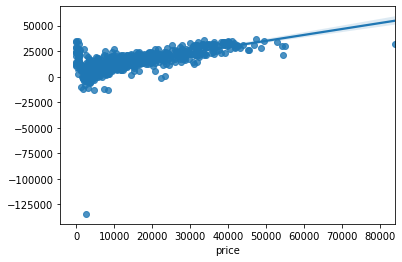

In [66]:
### Make prediction on test set
predictions = model.predict(X_val_scaled)
sns.regplot(y_val,predictions)

In [67]:
## calculate RMSE
def rmse(y_val,predictions):
    return np.sqrt(((y_val-predictions)**2).mean())

rmse(y_val, predictions)

9230.376735152466

In [68]:
## train model with X train+X_val and y_train+y_val
model = LinearRegression()
model.fit(pd.DataFrame(X_train_scaled).append(pd.DataFrame(X_val_scaled)), y_train.append(y_val))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
# print the parameters
parameters = pd.DataFrame(model.coef_,X_train.columns,columns=['Parameters'])
parameters["ABS_Parameters"] = parameters["Parameters"].apply(abs)
parameters = parameters.sort_values("ABS_Parameters", ascending = False)
parameters

,Parameters,ABS_Parameters
year,43163.523866,43163.523866
odometer_log,-33049.118672,33049.118672
odometer_log_dummy,-30580.219762,30580.219762
odometer,-23988.993848,23988.993848
F3,9081.841001,9081.841001
F1_log,6265.048025,6265.048025
type_pickup,6016.151660,6016.151660
type_truck,5686.226026,5686.226026
cylinders,4792.636122,4792.636122
condition,4293.633860,4293.633860


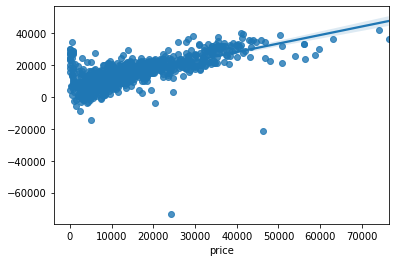

In [70]:
### Make prediction on test set
predictions = model.predict(X_test_scaled)
sns.regplot(y_test,predictions)

In [71]:
## calculate RMSE
def rmse(y_val,predictions):
    return np.sqrt(((y_val-predictions)**2).mean())

rmse(y_test, predictions)

8605.6613428311

# Ridge Regression

In [72]:
## hyperparameter search with trian set and val set
best_alpha = 0
best_rmse = 10**10
for a in np.arange(0,1,0.01):
    model = Ridge(normalize =True, alpha = a)
    model.fit(X_train_scaled, y_train)
    
    predictions = model.predict(X_val_scaled)
    rmse = math.sqrt(((predictions-y_val)**2).mean())
    
    if best_rmse>rmse:
        best_alpha = a
        best_rmse = rmse
        
print('best alpha : ',best_alpha)
print('best rmse : ', best_rmse)
    

best alpha :  0.54
best rmse :  8800.701216225174


In [73]:
## Fit final model trained with tran+val set and test with test set
model = Ridge(normalize =True, alpha = 0.54)
model.fit(pd.DataFrame(X_train_scaled).append(pd.DataFrame(X_val_scaled)), y_train.append(y_val))

##predict
predictions = model.predict(X_test_scaled)

##parameters
parameters = pd.DataFrame(model.coef_,X_train.columns,columns=['Parameters'])
parameters["ABS_Parameters"] = parameters["Parameters"].apply(abs)
parameters = parameters.sort_values("ABS_Parameters", ascending = False)
parameters

,Parameters,ABS_Parameters
year,29910.197978,29910.197978
odometer,-20106.478598,20106.478598
odometer_log,-11962.328678,11962.328678
odometer_log_dummy,-10848.045980,10848.045980
F3,6116.282248,6116.282248
F1_log,5998.622631,5998.622631
F1,5181.631970,5181.631970
condition,3875.922159,3875.922159
type_pickup,3798.480227,3798.480227
type_truck,3420.198489,3420.198489


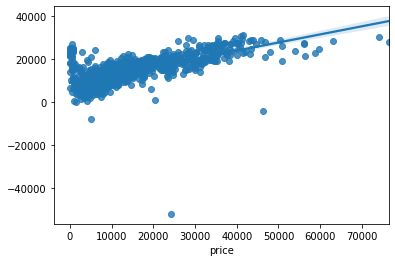

In [74]:
sns.regplot(y_test,predictions)

In [75]:
## calculate RMSE
rmse = math.sqrt(((predictions-y_test)**2).mean())
rmse

8699.539776307538

# Lasso

In [76]:
## hyperparameter search with train set and val set
best_alpha = 0
best_rmse = 10**10
for a in np.arange(0,1,0.01):
    model = Lasso(normalize = False,alpha = a)
    model.fit(X_train_scaled, y_train)
    
    predictions = model.predict(X_val_scaled)
    rmse = math.sqrt(((predictions-y_val)**2).mean())
    
    if best_rmse>rmse:
        best_alpha = a
        best_rmse = rmse
        
print('best alpha : ',best_alpha)
print('best rmse : ', best_rmse)
    

best alpha :  0.0
best rmse :  9230.376735152464


In [77]:
## Lasso Regression
# train model with (train +val) set and test it with test set

model = Lasso(alpha=0, normalize = True)

model.fit(pd.DataFrame(X_train_scaled).append(pd.DataFrame(X_val_scaled)), y_train.append(y_val))

Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [78]:
predictions = model.predict(X_test_scaled)

In [79]:
#print parameters
parameters = pd.DataFrame(model.coef_,X_train.columns,columns=['Parameters'])
parameters

,Parameters
year,43163.523866
manufacturer,2023.554873
condition,4293.633860
cylinders,4792.636122
odometer,-23988.993848
transmission,2278.053165
F1,-3759.865742
F3,9081.841001
odometer_log,-33049.118672
odometer_log_dummy,-30580.219762


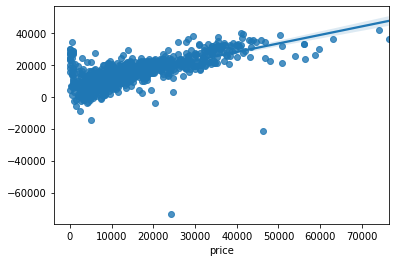

In [80]:
### Make prediction on test set
predictions = model.predict(X_test_scaled)
sns.regplot(y_test,predictions)

In [81]:
## calculate RMSE
def rmse(y_val,predictions):
    return np.sqrt(((y_val-predictions)**2).mean())

rmse(y_test, predictions)

8605.661342831097

# elastic net

In [82]:
### hyperparameter search for alpha(a) and l1_ratio(b)
best_alpha = 10**10
best_rmse = 10**10
for a in np.arange(0,1,0.01):
    for b in np.arange(0,1,0.1):
        model = ElasticNet(normalize = False, alpha = a, l1_ratio = b)
        model.fit(X_train_scaled, y_train)

        predictions = model.predict(X_val_scaled)
        rmse = math.sqrt(((predictions-y_val)**2).mean())

        if best_rmse>rmse:
            best_alpha = a
            best_l1 = b
            best_rmse = rmse
        
print('best alpha : ',best_alpha)
print('best l1_ratio : ',best_l1)
print('best rmse : ', best_rmse)
    

best alpha :  0.13
best l1_ratio :  0.9
best rmse :  8953.832594584432


In [83]:
model = ElasticNet(normalize = False, alpha = 0.13, l1_ratio = 0.9)
model.fit(pd.DataFrame(X_train_scaled).append(pd.DataFrame(X_val_scaled)), y_train.append(y_val))

ElasticNet(alpha=0.13, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

8803.887574889508


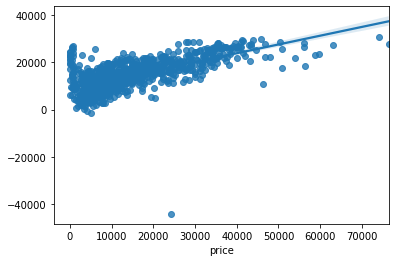

In [84]:
predictions = model.predict(X_test_scaled)

sns.regplot(y_test,predictions)

## calculate RMSE
rmse = math.sqrt(((predictions-y_test)**2).mean())
print(rmse)